In [1]:
import os
import time

import numpy as np
from tqdm import tqdm
from fidelity_simulation import FidelitySimulation
from pulse import RectangularReadoutPulse
from mock_file_creator import shift_s2p_freq_axis_minimal
from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter


In [2]:
# Measured frequencies
f01_meas = 3.845965050
f12_meas = 3.602264855

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fit_parameters()

fitter.print_results()

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.0841 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


In [3]:
TEMPLATE_FILE = "template_0ghz_resonator.s2p"

current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "data")
template_file_path = os.path.join(data_dir_path, TEMPLATE_FILE)

simulation_path = os.path.join(data_dir_path, time.strftime("%Y%m%d-%H%M%S"))


In [4]:
current_path = os.path.abspath("")
data_dir_path = os.path.join(current_path, "data")
s_parameters_file_state_0 = os.path.join(
    simulation_path,
    "original.s2p"
)

In [5]:
def run(s_parameters_file_state_1, pulse_frequency):
    pulse_length = 2 * 10 ** (-6)

    pulse_samples_number = 2 ** 23
    print("simulation dt =", pulse_length / pulse_samples_number * 10 ** 9, "ns")

    rect_readout_pulse = RectangularReadoutPulse(
        carrier_frequency=pulse_frequency,
        pulse_duration=pulse_length,
        pulse_power_dbm=-123,
        total_signal_time=pulse_length,
        pulse_samples_number=pulse_samples_number,
    )

    rect_readout_pulse.plot_pulse()

    fidelity_simulation = FidelitySimulation(
        s_parameters_file_state_0=s_parameters_file_state_0,
        s_parameters_file_state_1=s_parameters_file_state_1,
        readout_pulse=rect_readout_pulse,
        IQ_projection_frequency=pulse_frequency + 200e6,  # f_fi = 200MHz
        num_iterations=50,
        readout_dt=1e-9,
        plot_pulses=False,
        plot_result=True,
        disable_progress_bar=False,
    )

    return fidelity_simulation.run()


simulation dt = 0.0002384185791015625 ns


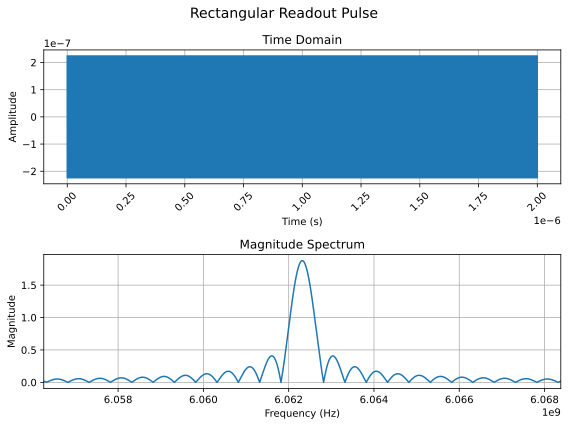

100%|██████████| 50/50 [00:30<00:00,  1.64it/s, Transited Pulse |1>]


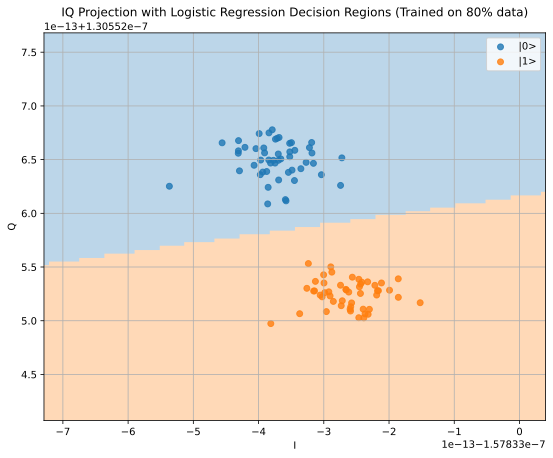

fidelity = 1.0
simulation dt = 0.0002384185791015625 ns


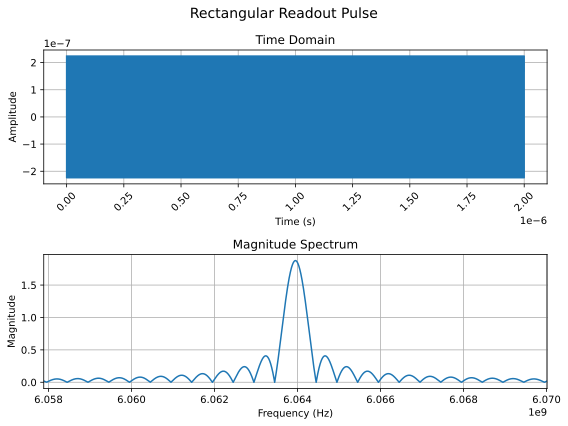

100%|██████████| 50/50 [00:30<00:00,  1.63it/s, Transited Pulse |1>]


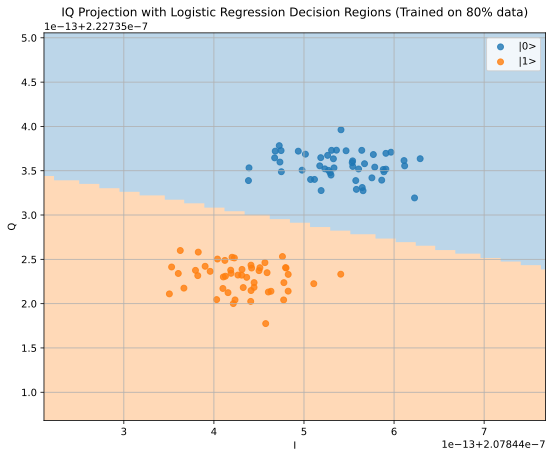

fidelity = 1.0
simulation dt = 0.0002384185791015625 ns


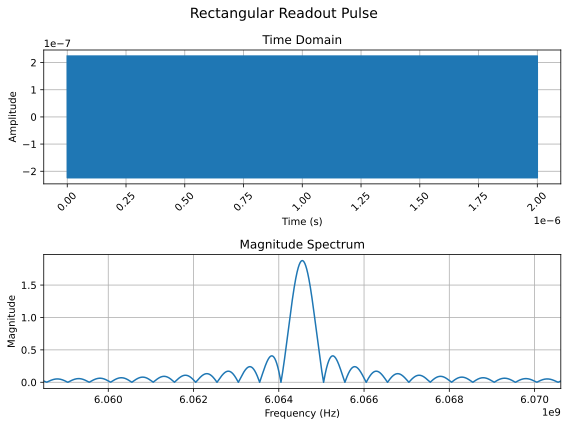

100%|██████████| 50/50 [00:30<00:00,  1.64it/s, Transited Pulse |1>]


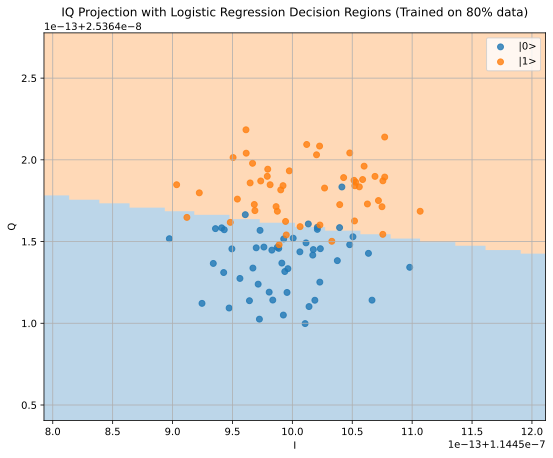

fidelity = 0.95
simulation dt = 0.0002384185791015625 ns


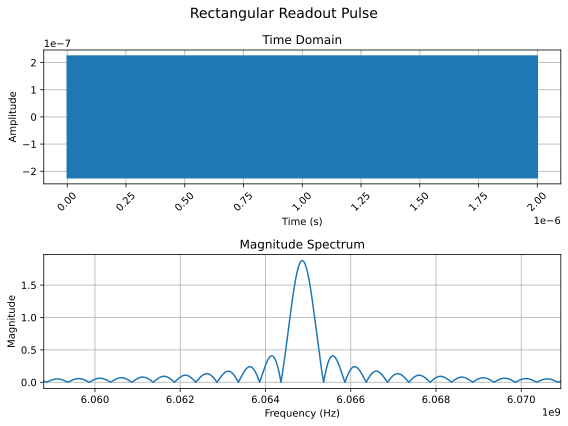

100%|██████████| 50/50 [00:34<00:00,  1.47it/s, Transited Pulse |1>]


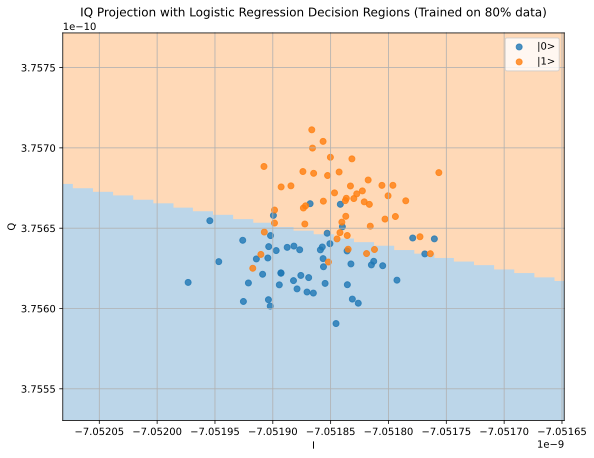

fidelity = 0.9
simulation dt = 0.0002384185791015625 ns


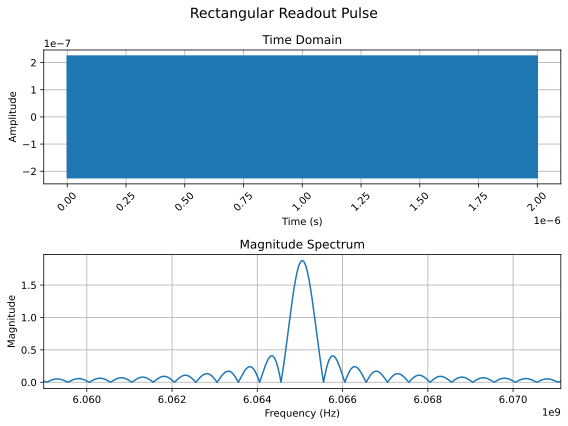

100%|██████████| 50/50 [00:31<00:00,  1.60it/s, Transited Pulse |1>]


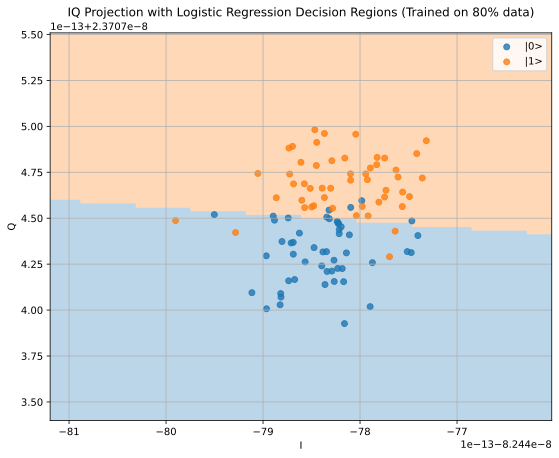

fidelity = 0.9
simulation dt = 0.0002384185791015625 ns


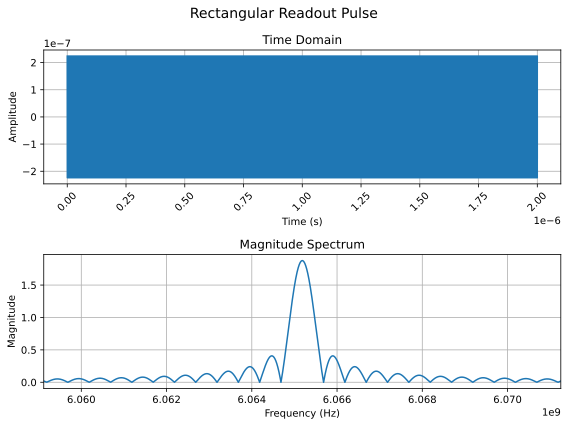

100%|██████████| 50/50 [00:29<00:00,  1.67it/s, Transited Pulse |1>]


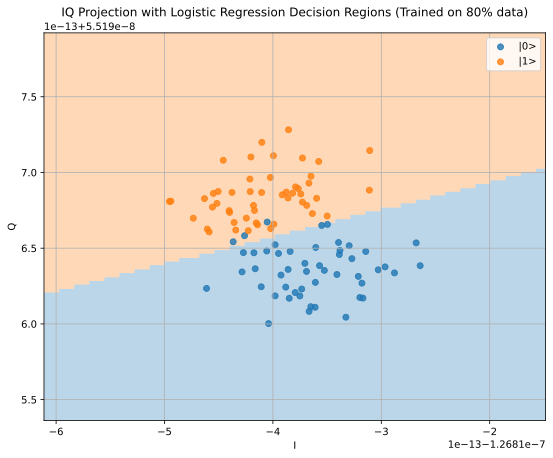

fidelity = 0.95
simulation dt = 0.0002384185791015625 ns


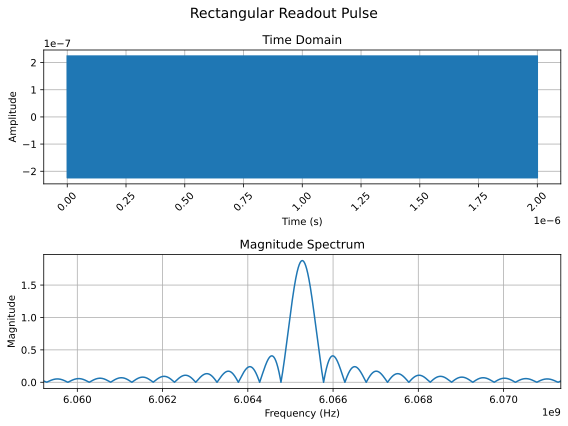

100%|██████████| 50/50 [00:37<00:00,  1.35it/s, Transited Pulse |1>]


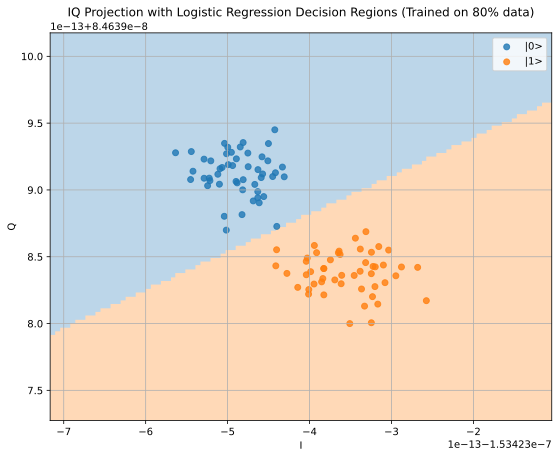

fidelity = 1.0
simulation dt = 0.0002384185791015625 ns


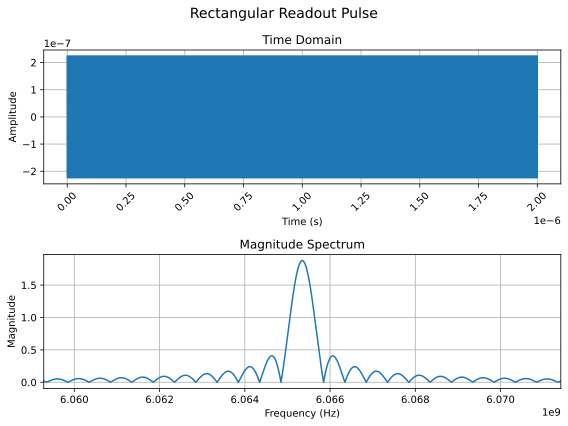

100%|██████████| 50/50 [00:30<00:00,  1.64it/s, Transited Pulse |1>]


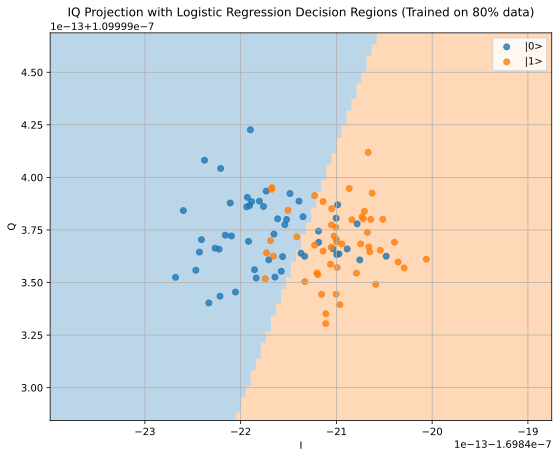

fidelity = 0.8


In [6]:
shift_s2p_freq_axis_minimal(template_file_path, os.path.join(simulation_path, "original.s2p"), fr0_meas)

delta_arr = -1 * np.linspace(1, 7, 7 + 1)
fidelities = []
for delta in delta_arr:
    chi = g_fitted ** 2 / delta
    f_pulse = (fr0_meas + chi / 2) * 10 ** 9

    file_state_1 = os.path.join(simulation_path, f"{delta}.s2p")
    shift_s2p_freq_axis_minimal(template_file_path, file_state_1, fr0_meas + chi)
    fidelity = run(file_state_1, f_pulse)
    fidelities.append(fidelity)
    print("fidelity =", fidelity)



In [9]:
fidelities

[1.0, 1.0, 0.95, 0.9, 0.9, 0.95, 1.0, 0.8]

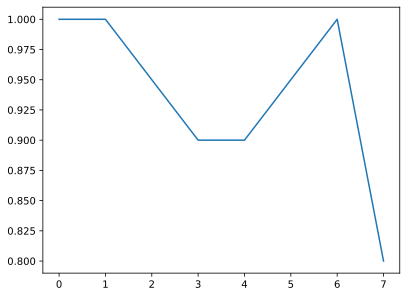

In [11]:
from matplotlib import pyplot as plt

plt.plot(fidelities)

In [8]:
g_fitted ** 2 / delta_arr


array([-0.00706725, -0.00380544, -0.00260372, -0.00197883, -0.00159583,
       -0.00133705, -0.00115048, -0.00100961])